- [20.2 - Hierarchical Bayesian Approach](#20.2---Hierarchical-Bayesian-Approach)
 - [20.2.3 - Main effect contrasts](#20.2.3---Main-effect-contrasts)

## Chapter 20 - Metric Predicted Variable with Multiple Nominal Predictors

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
def plot_mustache(var, sd, j, width=.75, ax=None):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        ax.plot(-xrange_scaled+j, yrange, color=color, alpha=.6)

### 20.2 - Hierarchical Bayesian Approach

In [4]:
df = pd.read_csv('data/Salary.csv', usecols=[0,3,5])

# Convert Org and Pos to category dtype.
df.loc[:,['Org', 'Pos']] = df.loc[:,['Org', 'Pos']].apply(lambda x: x.astype('category'))
# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
Org       1080 non-null category
Pos       1080 non-null category
Salary    1080 non-null int64
dtypes: category(2), int64(1)
memory usage: 11.1 KB


In [5]:
df.groupby('Pos').apply(lambda x: x.head(2))

              Org      Pos  Salary
Pos                               
Assis   4    LGED    Assis   63796
        6    INFO    Assis   98814
Assoc   0      PL    Assoc   72395
        1    MUTH    Assoc   61017
Full    7    CRIN     Full  107745
        9     PSY     Full  173302
Endow   5    MGMT    Endow  219600
        8    CRIN    Endow  114275
Disting 29   SPEA  Disting  285000
        128  MUHI  Disting  114189

#### Model (Kruschke, 2015)

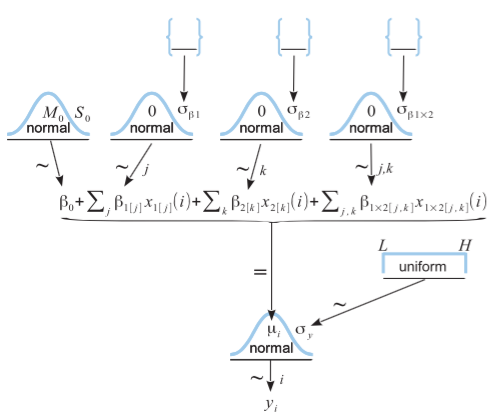

In [6]:
Image('images/fig20_2.png')

In [7]:
y = df.Salary
yMean = y.mean()
ySD = y.std()

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)

with pmc.Model() as model1:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a1SD = pmc.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    a1 = pmc.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a2SD = pmc.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    a2 = pmc.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    
    a1a2SD = pmc.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    a1a2 = pmc.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
    like = pmc.Normal('y', mu, tau=1/ySigma**2, observed=y)    

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied log-transform to a1SD and added transformed a1SD_log_ to model.
Applied log-transform to a2SD and added transformed a2SD_log_ to model.
Applied log-transform to a1a2SD and added transformed a1a2SD_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [8]:
n_samples = 10000
with model1:
    trace1 = pmc.sample(n_samples)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a1SD_log_
Assigned NUTS to a1
Assigned NUTS to a2SD_log_
Assigned NUTS to a2
Assigned NUTS to a1a2SD_log_
Assigned NUTS to a1a2
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 10001 of 10000 complete in 138.9 sec

In [9]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1))[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,12]))
print('ySigma: {}'.format(np.round(np.mean(trace1['ySigma']))))

b0: 127073.0
b1: [-46301. -33033.  -3144.  26952.  55526.]
b2: [ -19409.    6721.   19193.  109179.]
b1b2: -3444.0
b1b2: -15190.0
b1b2: -12893.0
b1b2: 13044.0
ySigma: 18151.0


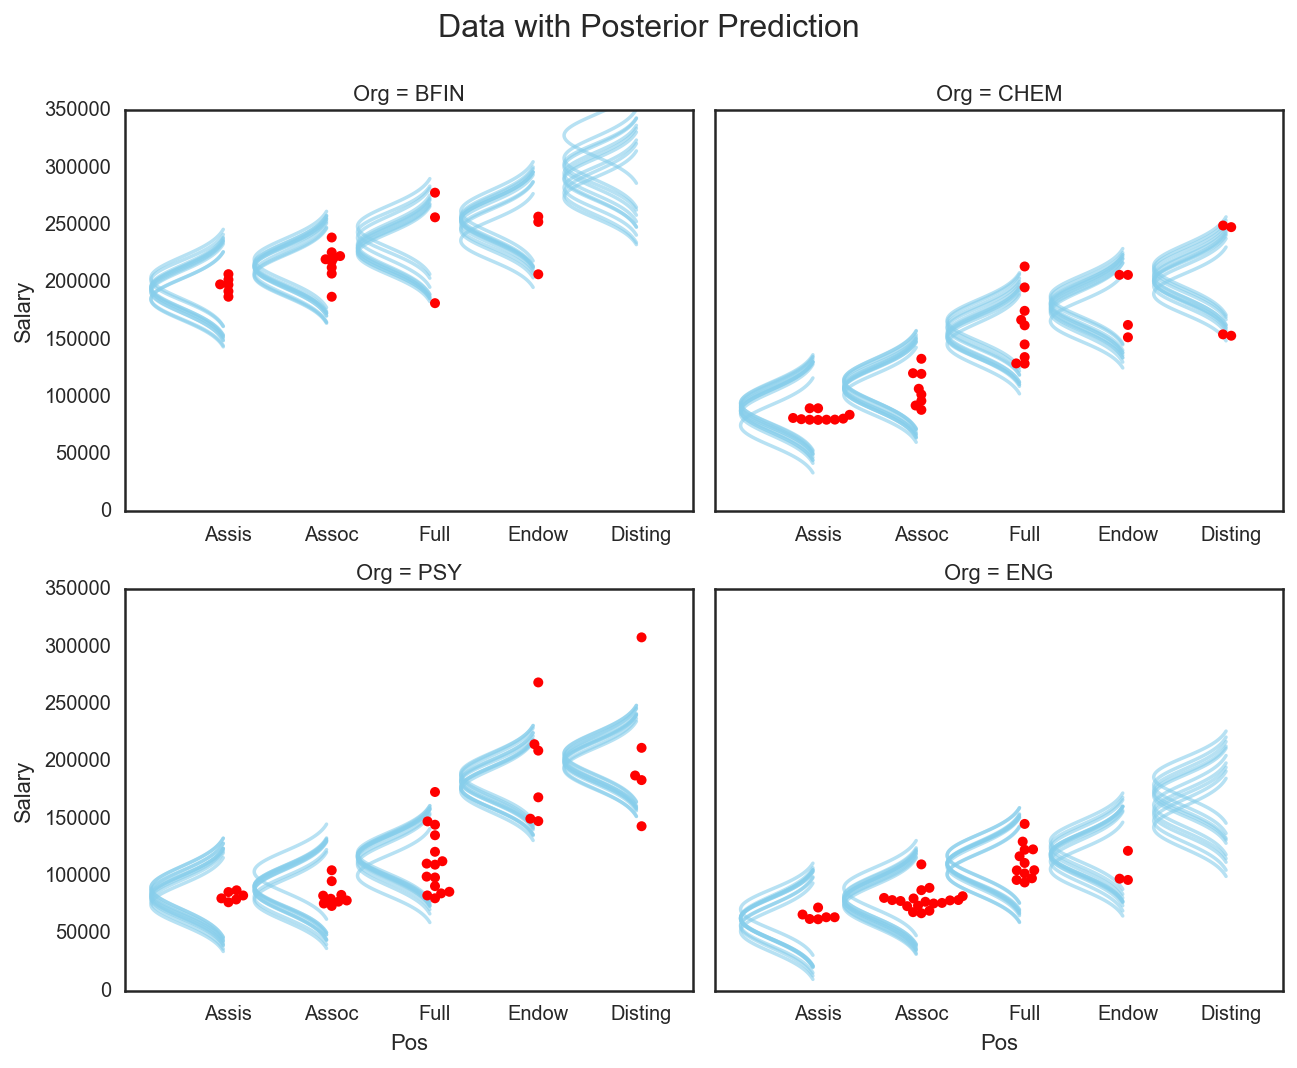

In [10]:
burnin = 200
scale = trace1['ySigma'][burnin:]

# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16)
for ax in fg.axes:
    ax.set_xlim(xmin=-1)
    ax.set_ylim(ymin=0)
    
for i, org_idx in enumerate([7,12,48,20]):
    for pos_idx in np.arange(5):
        plot_mustache(b0[burnin:]+
                      b1[pos_idx, burnin:]+
                      b2[org_idx,burnin:]+
                      b1b2[pos_idx,org_idx,burnin:], scale, pos_idx, ax=fg.axes.flatten()[i])

### 20.2.3 - Main effect contrasts

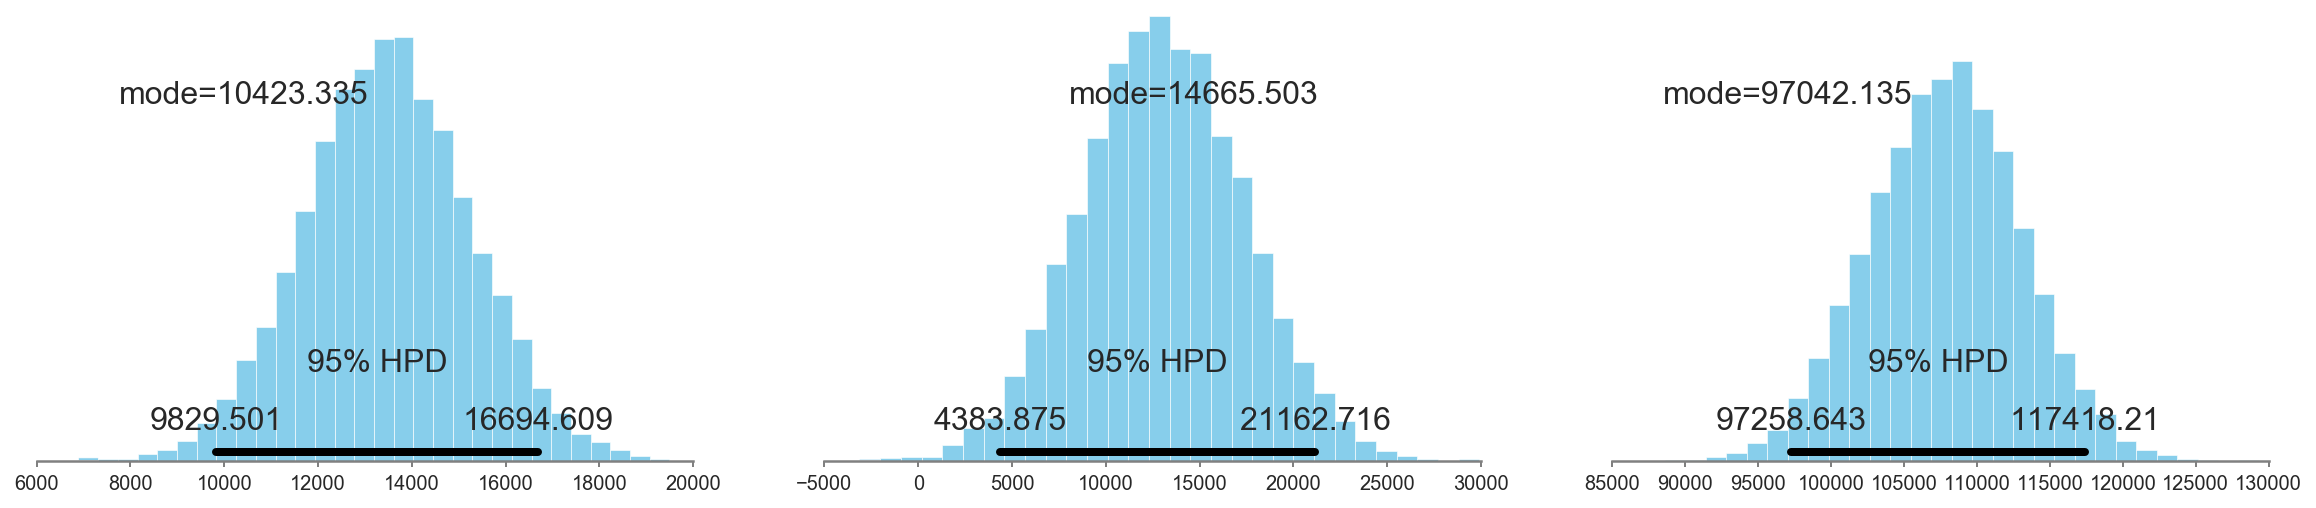

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,4))

pmc.plot_posterior((b1[1,burnin:])-(b1[0,burnin:]), color=color, point_estimate='mode', ax=ax1)
pmc.plot_posterior(b2[12,burnin:]-b2[48,burnin:], color=color, point_estimate='mode', ax=ax2)
pmc.plot_posterior(b2[7,burnin:]-np.mean([b2[48,burnin:],
                                          b2[12,burnin:],
                                          b2[20,burnin:]], axis=0), color=color, point_estimate='mode', ax=ax3);